<a href="https://colab.research.google.com/github/appersaravanan/Semeter-2-Assignment-1/blob/master/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Input,Flatten,Dense,GaussianNoise,Activation,AveragePooling2D,\
    ZeroPadding2D,BatchNormalization,DepthwiseConv2D,GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
from math import ceil, floor
import random
from random import randrange
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

Question: Study and visualize the error surfaces in optimization, discuss your discovery/thinking along with the implementation.

Steps:

1. Data and Model Preparation.

1-1. (Down)load and preprocess MNIST (as in assignments 1 and 2) Display example images (suggesting 16).

1-2. Implement (reuse) the same LeNet-5 (as in assignment 2) Print your implemented model structure by function "summary".

1-3. Implement (use) the MobileNet.  (Links to an external site.)Note that for MNIST, we need to change the input and output shapes(see one reference (Links to an external site.)). Print your implemented model structure by function "summary".

 

2. Training.

Train both your implemented [2-1] and [2-2] models with MNIST. Plot the training results (epochs v.s. loss values on both the training and validation sets). Determine your stopping epoch based on the training results for each of the models.

2-1. LeNet-5

2-2. MobileNet

 

3. Error Surface Studies.

3-1. Conduct similar experiments as discussed in Page 11, Lecture 6-2 with these implemented LeNet-5 and MobileNet models.

i.e., visualizing the paramters 𝜃
θ
 versus the loss values, where the 𝜃
θ
 changes at a linear direction 𝜃=(1−𝛼)𝜃𝑖𝑛𝑖𝑡+𝛼𝜃𝑓𝑖𝑛𝑎𝑙
θ
=
(
1
−
α
)
θ
i
n
i
t
+
α
θ
f
i
n
a
l
 as discussed in the reference paper in the slide. Plot similarly formatted figure(s) as in the lecture slide (a major difference: each curve is for a different activation in the lecture discussion, while we want to plot results for two different models here in this assignment).

3-2. Conduct similar experiments as discussed in Page 15, Lecture 6-2 with this implemented LeNet-5 and MobileNet models. Plot similarly formatted figure(s) as in the lecture slide (plot results for two different models here in this assignment).

In [3]:
def show_imgs(images):
    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(images[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

# Step 1.  Load MNIST dataset
1-1. (Down)load and preprocess MNIST (as in assignments 1 and 2) Display example images (suggesting 16)

In [4]:

(x_train,y_train),(x_test,y_test) =mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


#Samples Before Normalization 

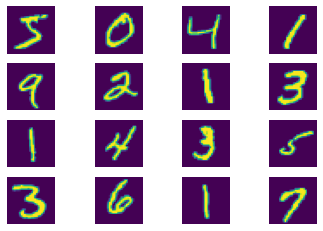

In [5]:
show_imgs(x_train)

In [6]:

print(x_train.min() , x_train.max())
x_train = x_train- x_train.min() / x_train.max()- x_train.min()
x_train =x_train/255

print(x_train.min() , x_train.max())
x_test = x_test- x_test.min() / x_test.max()- x_test.min()
x_test =x_test/255
print(x_test.min() , x_test.max())
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)



0 255
0.0 1.0
0.0 1.0


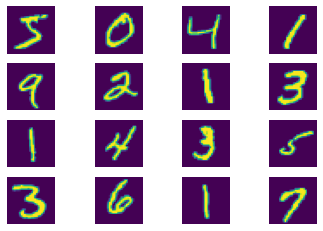

In [7]:
show_imgs(x_train)

# Normalization and one hot encodings


In [8]:
def _depthwise_sep_conv(x, filters, alpha, strides = (1, 1)):
    
    y = DepthwiseConv2D((3, 3), padding = 'same', strides = strides)(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(int(filters * alpha), (1, 1), padding = 'same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [9]:
alpha = 1 # 0 < alpha <= 1
x = Input(shape = (28, 28, 1))
y = ZeroPadding2D(padding = (2, 2))(x) # matching the image size of CIFAR-10

# some layers have different strides from the papers considering the size of mnist
y = Conv2D(int(32 * alpha), (3, 3), padding = 'same')(y) # strides = (2, 2) in the paper
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = _depthwise_sep_conv(y, 64, alpha) # spatial size: 32 x 32
y = _depthwise_sep_conv(y, 128, alpha, strides = (2, 2)) # spatial size: 32 x 32
y = _depthwise_sep_conv(y, 128, alpha) # spatial size: 16 x 16
y = _depthwise_sep_conv(y, 256, alpha, strides = (2, 2)) # spatial size: 8 x 8
y = _depthwise_sep_conv(y, 256, alpha) # spatial size: 8 x 8
y = _depthwise_sep_conv(y, 512, alpha, strides = (2, 2)) # spatial size: 4 x 4
for _ in range(5):
    y = _depthwise_sep_conv(y, 512, alpha) # spatial size: 4 x 4
y = _depthwise_sep_conv(y, 1024, alpha, strides = (2, 2)) # spatial size: 2 x 2
y = _depthwise_sep_conv(y, 1024, alpha) # strides = (2, 2) in the paper
y = GlobalAveragePooling2D()(y)
y = Dense(units = 10)(y)
y = Activation('softmax')(y)

new_model= Model(x, y)

In [10]:
new_model.summary()
callbacks = [ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                       patience = 30, verbose = 1)]
optimizer = optimizers.RMSprop(lr = 0.01)
new_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy',])
# new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',])

data=new_model.fit(x_train,y_train,epochs=350,steps_per_epoch=10,callbacks=callbacks,validation_split=0.3,shuffle=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128   

KeyboardInterrupt: ignored

In [18]:
y_test.shape 
new_model.evaluate(x_test,y_test);

313/313 [==============================] - 2s 5ms/step - loss: 0.0625 - accuracy: 0.9936


In [16]:
input=Input(shape=[28, 28,1])
x=Conv2D(filters = 6,kernel_size = 5, strides = 1,activation = 'tanh',)(input)

x=MaxPool2D(pool_size = 2, strides = 2)(x)
x=Conv2D(filters = 16, kernel_size = 5,strides = 1,activation = 'tanh')(x)

x=MaxPool2D(pool_size = 2, strides = 2)(x)
x=Flatten()(x)
x=Dense(units = 120, activation = 'tanh')(x)
x=Dense(units = 84, activation = 'tanh')(x)
x=Dense(units = 10, activation = 'softmax')(x)

model=Model(inputs=input,outputs=x)
model.summary()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               3084

In [45]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
data=model.fit(x_train,y_train,epochs=100,steps_per_epoch=10,validation_split=0.3,callbacks=[es],shuffle=True)

Epoch 1/100
10/10 [==============================] - 2s 162ms/step - loss: 2.1382 - accuracy: 0.3264 - val_loss: 1.5282 - val_accuracy: 0.7238
Epoch 2/100
10/10 [==============================] - 1s 146ms/step - loss: 1.3352 - accuracy: 0.7462 - val_loss: 0.7970 - val_accuracy: 0.8331
Epoch 3/100
10/10 [==============================] - 1s 144ms/step - loss: 0.7161 - accuracy: 0.8376 - val_loss: 0.4895 - val_accuracy: 0.8812
Epoch 4/100
10/10 [==============================] - 1s 142ms/step - loss: 0.4659 - accuracy: 0.8817 - val_loss: 0.3695 - val_accuracy: 0.9031
Epoch 5/100
10/10 [==============================] - 1s 142ms/step - loss: 0.3624 - accuracy: 0.9044 - val_loss: 0.3046 - val_accuracy: 0.9173
Epoch 6/100
10/10 [==============================] - 1s 153ms/step - loss: 0.3023 - accuracy: 0.9169 - val_loss: 0.2606 - val_accuracy: 0.9274
Epoch 7/100
10/10 [==============================] - 1s 158ms/step - loss: 0.2570 - accuracy: 0.9284 - val_loss: 0.2273 - val_accuracy: 0.9364

In [47]:
model.metrics_names
https://github.com/artur-deluca/landscapeviz/blob/41c2bf4d7bc5f044e9462ce46661a33e6bd51fd6/landscapeviz/utils.py#L81

['loss', 'accuracy']

In [ ]:
vector_x, vector_y = list(), list()
cast = np.array([1]).T
np.random.seed(None)
for layer in new_model.get_weights():
    
    k = len(layer.shape) -1
    print(k)
    d = np.random.multivariate_normal(
        [0], np.eye(1), layer.shape).reshape(layer.shape)
    
    
    val=(
        d/(1e-10 + cast*np.linalg.norm(d))[:, np.newaxis])
    
    print(len(val))
    dist_x = val.reshape(d.shape)

    vector_x.append(
        (dist_x * (cast*np.linalg.norm(layer))
          [:, np.newaxis]).reshape(d.shape)
    )

    d = np.random.multivariate_normal(
        [0], np.eye(1), layer.shape).reshape(layer.shape)
    dist_y = (
        d/(1e-10 + cast*np.linalg.norm(d))[:, np.newaxis]).reshape(d.shape)

    vector_y.append(
        (dist_y * (cast*np.linalg.norm(layer))
          [:, np.newaxis]).reshape(d.shape)
    )
print(len(vector_x));
print(len(vector_y))

#2. Implement LeNet-5 with Keras functional API (Links to an external site.). Output/Print your implemented model structure by function "summary (Links to an external site.)".

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 120)               308

# 3.Train your implemented LeNet-5 model with MNIST. Plot the training results (epochs v.s. loss values on both the training and validation sets). Determine your stopping epoch based on the traning results.

In [ ]:
score = model.evaluate(x_test, y_test);
print('score Loss- ', score[0])
print('score accuracy -', score[1])



313/313 [==============================] - 1s 2ms/step - loss: 0.0672 - accuracy: 0.9781
score Loss-  0.06723818928003311
score accuracy - 0.9781000018119812


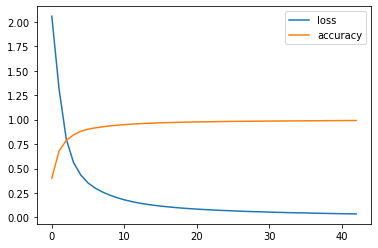

In [ ]:
from matplotlib import pyplot
pyplot.plot(data.history['loss'] ,label='loss')
pyplot.plot(data.history['accuracy'] ,label='accuracy')
pyplot.legend()
pyplot.show()

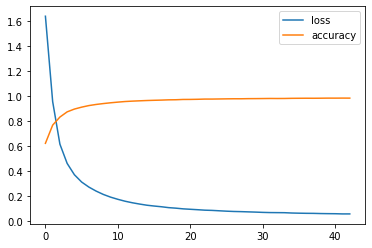

In [ ]:
from matplotlib import pyplot
pyplot.plot(data.history['val_loss'] ,label='loss')
pyplot.plot(data.history['val_accuracy'] ,label='accuracy')
pyplot.legend()
pyplot.show()

In [ ]:
input=Input(shape=[28, 28,1])
x=Conv2D(filters = 6,kernel_size = 5, strides = 1)(input)
x=Activation ('tanh')(x)
x=MaxPool2D(pool_size = 2, strides = 2)(x)
x=Conv2D(filters = 16, kernel_size = 5,strides = 1)(x)
x=Activation ('tanh')(x)
x=MaxPool2D(pool_size = 2, strides = 2)(x)
x=Flatten()(x)
x=Dense(units = 120, activation = 'tanh')(x)
x=Dense(units = 84, activation = 'tanh')(x)
x=Dense(units = 10, activation = 'softmax')(x)

model=Model(inputs=input,outputs=x)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.summary()
# data=model.fit(x_train,y_train,epochs=20,steps_per_epoch=10,validation_split=0.3,callbacks=[es],shuffle=True)

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
activation_16 (Activation)   (None, 24, 24, 6)         0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
activation_17 (Activation)   (None, 8, 8, 16)          0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 4, 4, 16)          0  

In [ ]:
score=model.evaluate(x_test,y_test)
print(score[0])
print(score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0801 - accuracy: 0.9763
0.08008863776922226
0.9763000011444092


In [ ]:
 from keras.callbacks import Callback

class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, batch, logs=None):
    # print(self.model.layers[self.index].stddev)
    self.model.layers[self.index].stddev = self.stdval;
    if self.stdval<10:
     self.stdval +=.5
    print(self.model.layers[self.index])
    print(self.stdval)



In [ ]:
history_arr=list();
x_axis=[]
noise_index=[1,3,7,11,14,17]
noise_index=[0,1,3,5,6,7]
x
noise=0
for index in range(len(noise_index)):
  for model_index in range(len(model.layers)):
    
    if model_index==0:
      x= model.layers[model_index].output
      if noise_index[index]==0:
        x = GaussianNoise(noise)(x,training=True)
    elif noise_index[index]==model_index:
      x = model.layers[model_index](x)
      x = GaussianNoise(noise)(x,training=True)
     
    else :
      x = model.layers[model_index](x)
  new_model=Model(model.input,x)
  # new_model.summary()
  new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',])
  
  callback=MyCustomCallback()
  callback.stdval=noise
  callback.index=noise_index[index]

  
  #model.fit(x_train,y_train,epochs=500,steps_per_epoch=20,validation_split=0.3,callbacks=[es,accuracy])
  history=new_model.fit(x_train,y_train,epochs=20,steps_per_epoch=10,validation_split=0.3,callbacks=[callback],shuffle=True)
  history_arr.append(history.history)

Epoch 1/20
0.5
10/10 [==============================] - 2s 180ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0598 - val_accuracy: 0.9856
Epoch 2/20
1.0
10/10 [==============================] - 1s 158ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0576 - val_accuracy: 0.9858
Epoch 3/20
1.5
10/10 [==============================] - 2s 164ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0594 - val_accuracy: 0.9858
Epoch 4/20
2.0
10/10 [==============================] - 2s 166ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9858
Epoch 5/20
2.5
10/10 [==============================] - 1s 162ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9862
Epoch 6/20
3.0
10/10 [==============================] - 2s 164ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9862
Epoch 7/20
3.5
10/10 [==============================] - 1s 163ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0588 -

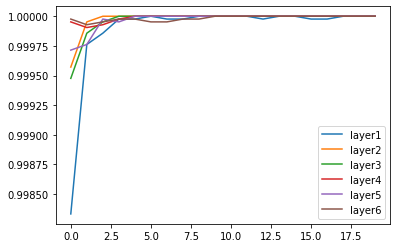

In [ ]:
from matplotlib import pyplot

pyplot.plot(history_arr[0]['accuracy'] ,label='layer1')
pyplot.plot(history_arr[1]['accuracy'] ,label='layer2')
pyplot.plot(history_arr[2]['accuracy'] ,label='layer3')

pyplot.plot(history_arr[3]['accuracy'],label='layer4')
pyplot.plot(history_arr[4]['accuracy'],label='layer5')
pyplot.plot(history_arr[5]['accuracy'],label='layer6')

pyplot.legend()
pyplot.show()

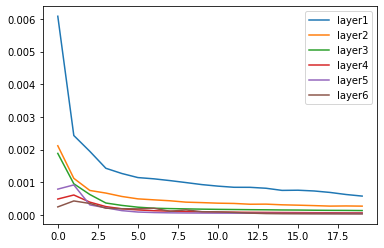

In [ ]:
from matplotlib import pyplot

pyplot.plot(history_arr[0]['loss'] ,label='layer1')
pyplot.plot(history_arr[1]['loss'] ,label='layer2')
pyplot.plot(history_arr[2]['loss'] ,label='layer3')

pyplot.plot(history_arr[3]['loss'],label='layer4')
pyplot.plot(history_arr[4]['loss'],label='layer5')
pyplot.plot(history_arr[5]['loss'],label='layer6')

pyplot.legend()
pyplot.show()

In [ ]:

training_index=1
history_tranining_arr=list()
for l in model.layers:
    print(l.name, l.trainable)
    l.trainable=False
layer_index=[1,3,6,7]
# for index in range(len(model.layers)):
train_count=0
for index in range(len(layer_index)):
    input=Input(shape=[28, 28,1])
    x=Conv2D(filters = 6,kernel_size = 5, strides = 1,activation = 'tanh',)(input)

    x=MaxPool2D(pool_size = 2, strides = 2)(x)
    x=Conv2D(filters = 16, kernel_size = 5,strides = 1,activation = 'tanh')(x)

    x=MaxPool2D(pool_size = 2, strides = 2)(x)
    x=Flatten()(x)
    x=Dense(units = 120, activation = 'tanh')(x)
    x=Dense(units = 84, activation = 'tanh')(x)
    x=Dense(units = 10, activation = 'softmax')(x)

    model=Model(inputs=input,outputs=x)
    
    model.summary()
    
   
    for l in model.layers:      
      l.trainable=False
      print(l)
    
    model.layers[layer_index[index]].trainable=True
    print(model.layers[index]) 
    for l in model.layers:            
      print(str(l) + str(l.trainable))  
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',])
    model.summary()
   
    history=model.fit(x_train,y_train,epochs=50,steps_per_epoch=10,validation_split=0.3,shuffle=True)
    history_tranining_arr.append(history.history)
    training_index+=1
    print('================================================================================================================================')

   
    


input_62 False
conv2d_121 False
max_pooling2d_117 False
conv2d_122 False
max_pooling2d_118 False
flatten_60 False
dense_174 False
dense_175 False
dense_176 False
Model: "model_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_61 (Flatten)        

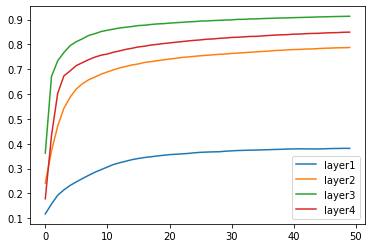

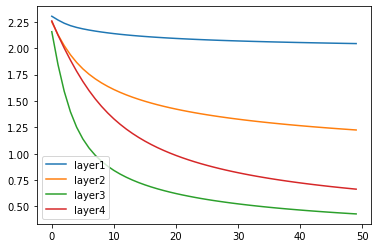

In [ ]:
from matplotlib import pyplot

pyplot.plot(history_tranining_arr[0]['accuracy'] ,label='layer1')
pyplot.plot(history_tranining_arr[1]['accuracy'] ,label='layer2')
pyplot.plot(history_tranining_arr[2]['accuracy'] ,label='layer3')

pyplot.plot(history_tranining_arr[3]['accuracy'],label='layer4')

# pyplot.plot(history_tranining_arr[5]['accuracy'],label='layer6')

pyplot.legend()
pyplot.show()

from matplotlib import pyplot

pyplot.plot(history_tranining_arr[0]['loss'] ,label='layer1')
pyplot.plot(history_tranining_arr[1]['loss'] ,label='layer2')
pyplot.plot(history_tranining_arr[2]['loss'] ,label='layer3')

pyplot.plot(history_tranining_arr[3]['loss'],label='layer4')

# pyplot.plot(history_tranining_arr[5]['accuracy'],label='layer6')

pyplot.legend()
pyplot.show()

#Sample after normalization

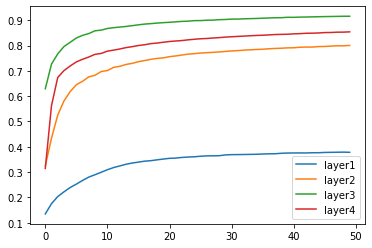

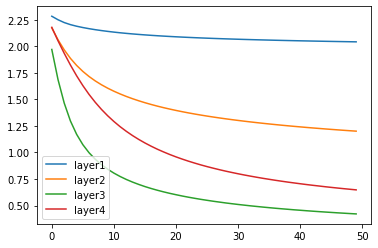

In [ ]:
from matplotlib import pyplot

pyplot.plot(history_tranining_arr[0]['val_accuracy'] ,label='layer1')
pyplot.plot(history_tranining_arr[1]['val_accuracy'] ,label='layer2')
pyplot.plot(history_tranining_arr[2]['val_accuracy'] ,label='layer3')

pyplot.plot(history_tranining_arr[3]['val_accuracy'],label='layer4')

# pyplot.plot(history_tranining_arr[5]['accuracy'],label='layer6')

pyplot.legend()
pyplot.show()
from matplotlib import pyplot

pyplot.plot(history_tranining_arr[0]['val_loss'] ,label='layer1')
pyplot.plot(history_tranining_arr[1]['val_loss'] ,label='layer2')
pyplot.plot(history_tranining_arr[2]['val_loss'] ,label='layer3')

pyplot.plot(history_tranining_arr[3]['val_loss'],label='layer4')

# pyplot.plot(history_tranining_arr[5]['accuracy'],label='layer6')

pyplot.legend()
pyplot.show()